In [7]:
queryDt='170714135400'

In [2]:
import glob
import numpy as np
import re
import pyart
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/nlim/miniconda3/envs/pyradar/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/home/nlim/miniconda3/envs/pyradar/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p17 = _nlv < LooseVersion("1.17")
/home/nlim/miniconda3/envs/pyradar/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p18 = _nlv < LooseVersion("1.18")
/home/nlim/miniconda3/envs/pyradar/lib/python3.8/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p19 = _nlv < LooseVersion("1.19")
/home/nlim/miniconda3/envs/pyradar/li

In [6]:

def find_nearest(array,value):
    array=np.asarray(array)
    idx=(np.abs(array-value)).argmin()
    return array[idx]

def find_nearest_idx(array,value):
    array=np.asarray(array)
    idx=(np.abs(array-value)).argmin()
    return idx


aklFiles=glob.glob('/media/nlim/My Passport/nz_radar/*/*/AKL*.RAWSURV')
aklList=[]
for file in aklFiles:
    m=re.search('(\\d+).RAWSURV',file)
    aklList.append(int(m.group(1)))

bopFiles=glob.glob('/media/nlim/My Passport/nz_radar/*/*/BOP*.RAWSURV')
bopList=[]
for file in bopFiles:
    m=re.search('(\\d+).RAWSURV',file)
    bopList.append(int(m.group(1)))

reflectance=[]
enddt=int(queryDt)
startdt=int(queryDt)-100

startIdx=find_nearest_idx(aklList,startdt)
endIdx=find_nearest_idx(aklList,enddt)


In [4]:
myMa=[]
for fileNo in range(endIdx,endIdx+1):
        akldt=aklList[fileNo]
        print(akldt)
        aklMonth=str(akldt)[2:4]
        aklYear=str(2000+int(str(akldt)[0:2]))
        bopdt=str(find_nearest(bopList,akldt))
        bopMonth=str(bopdt)[2:4]
        bopYear=str(2000+int(str(bopdt)[0:2]))
        file1='/media/nlim/My Passport/nz_radar/'+aklYear+'/'+aklMonth+'/AKL'+str(akldt)+'.RAWSURV'
        file2='/media/nlim/My Passport/nz_radar/'+bopYear+'/'+bopMonth+'/BOP'+str(bopdt)+'.RAWSURV'
        radar_files=[file1, file2]
        radars = [pyart.io.read(file) for file in radar_files]
        filters = []
        for radar in radars:
            gatefilter = pyart.correct.despeckle.despeckle_field(radar, 'reflectivity',
                                                         threshold=-100, size=20)
            gatefilter.exclude_transition()
            gatefilter.exclude_above('reflectivity', 80)
            filters.append(gatefilter)           
        grid = pyart.map.grid_from_radars(radars, gatefilters=filters,
                                  grid_shape= (5, 250, 350),
                                  grid_limits= ([0.0, 10000.0], [-25000.0, 25000.0], [-35000.0, 35000.0]),
                                  fields=['reflectivity'],
                                  max_refl= 80.,
                                  copy_field_data= True,
                                  grid_origin= (-37.0428, 175.6819),
                                  roi_func= 'dist_beam',
                                  min_radius= 500.0,
                                  h_factor= 1.0,
                                  nb= 1.0,
                                  bsp= 1.0
                                 )                               
        myMa.append(grid.fields['reflectivity']['data'][0,:,:])


NameError: name 'endIdx' is not defined

In [3]:
import pandas as pd
df_pred=pd.read_csv(f'batchmode/bayesianTest/csvOut/bayesian_LSTM_6hr_epoch_80_alpha_200_opitonui.csv')
flood_index=np.abs(df_pred['gt'].to_numpy())>0.15
pred=df_pred['pred']
gt=df_pred['gt']
pred_sd=df_pred['pred_sd']
df = pd.read_csv('merged_full.csv')
dtStr=str(queryDt)
year=2000+int(dtStr[0:2])
mont=str(int(dtStr[2:4])).zfill(2)
day=str(int(dtStr[4:6])).zfill(2)
hr=str(int(dtStr[6:8])).zfill(2)
min=str(int(dtStr[8:10])).zfill(2)
sec=str(int(dtStr[10:12])).zfill(2)
dfSrch=f'{year}-{mont}-{day} {hr}:{min}:{sec}+00:00'
dfIndex=df.datetimeUTC.searchsorted(dfSrch)-1
lookback=int(3*24*60/15)
tairua=df['Tairua'][dfIndex:dfIndex+lookback]
actualDT=df['datetimeUTC'][dfIndex:dfIndex+lookback]
opitonui=df['Opitonui'][dfIndex:dfIndex+lookback]
crrain=df['CR Rain'][dfIndex:dfIndex+lookback]
pinnacles=df['Pinnacles Rain'][dfIndex:dfIndex+lookback]
predictionWindow=int(12*60/15)
df_pred2=df_pred.reindex(range(len(df_pred)+dfIndex+lookback))
df_pred2=df_pred.shift(dfIndex+lookback)
df_pred2=df_pred
df_pred2=df_pred2.reindex(range(len(df_pred)+dfIndex+lookback))
df_pred2=df_pred2.shift(dfIndex+lookback)
pred=df_pred2['pred'][dfIndex+lookback:dfIndex+lookback+predictionWindow]
pred_sd=df_pred2['pred_sd'][dfIndex+lookback:dfIndex+lookback+predictionWindow]
pred=pred*3+1.3
pred_sd=pred_sd*3

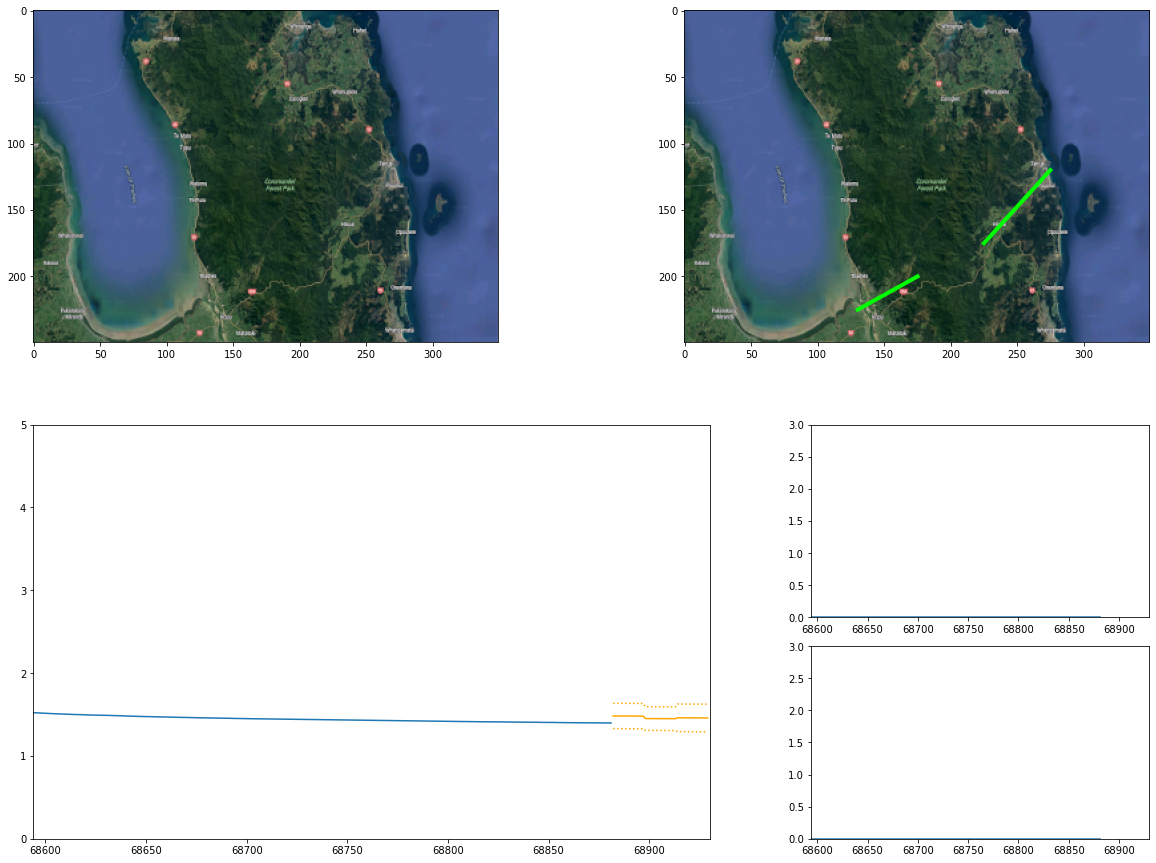

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

fig = plt.figure(figsize=(20, 16))
main_grid=fig.add_gridspec(2, 1, wspace=0.1, hspace=0.1)
radar_grid = main_grid[0, 0].subgridspec(1, 2, wspace=0.4, hspace=0.05)
radar_ax=fig.add_subplot(radar_grid[0])
map_ax=fig.add_subplot(radar_grid[1])
#ts_grid= main_grid[1, 0].subgridspec(3, 1, wspace=0.2, hspace=0.15,height_ratios=[2,1,1])
ts_grid= main_grid[1, 0].subgridspec(1, 2, wspace=0.2, hspace=0.15,width_ratios=[2,1])
ts_grid2= ts_grid[0, 1].subgridspec(2, 1, wspace=0.2, hspace=0.15,height_ratios=[1,1])

pred_ax=fig.add_subplot(ts_grid[0])
rain_ax=fig.add_subplot(ts_grid2[0])
river_ax=fig.add_subplot(ts_grid2[1])

import matplotlib.image as mpimg
tauranga=mpimg.imread('tauranga.png')
def init():
      global radar_ax, im, im_base
      im_base=radar_ax.imshow(tauranga)
      im=radar_ax.imshow(myMa[0],cmap='ocean', alpha=0.7)
      #im.set_data(np.zeros(myMa[0].shape))

def animate(n):
    im.set_data(myMa[n])
    return
init()
#ani=animation.FuncAnimation(fig,animate, frames=104, interval=120, blit=False)
map_ax.imshow(tauranga)
map_ax.plot([225,275],[175,120],lw=4,color='lime')
map_ax.plot([130,175],[225,200],lw=4,color='lime')

rain_ax.plot(crrain)
rain_ax.set_xlim([dfIndex,dfIndex+lookback+predictionWindow])
rain_ax.set_ylim([0,3])

river_ax.plot(pinnacles)
river_ax.set_xlim([dfIndex,dfIndex+lookback+predictionWindow])
river_ax.set_ylim([0,3])

pred_ax.plot(tairua)
pred_ax.set_xlim([dfIndex,dfIndex+lookback+predictionWindow])
pred_ax.set_ylim([0,5])

pred_ax.plot(pred,color='orange')
pred_ax.plot(pred+2*pred_sd,':',color='orange')
pred_ax.plot(pred-2*pred_sd,':',color='orange')

#plt.show()